In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.inferences import VariationalInference
from edward.models import Bernoulli, Normal, RandomVariable
from edward.util import copy
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

ed.set_seed(42)

import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

In [2]:
# use custom helper functions from src folder
import sys
sys.path.insert(0, '../src/')

from data import *
from inference import *
from helpers import *
from model_zoo import conv_lstm 

Using TensorFlow backend.


### DATA

In [3]:
# for this basic example, lets only examine a small subset of the data
%pdb on
N = 10000  # number of data points
D = 50  # number of features
X_data, y_data, X_test, y_test = get_dataset(N=N,D=D, make_balanced=True)
print('shapes (X,y),', X_data.shape, y_data.shape)

Automatic pdb calling has been turned ON
shapes (X,y), (9920, 50) (9920,)


In [4]:
y_data.mean()

0.5

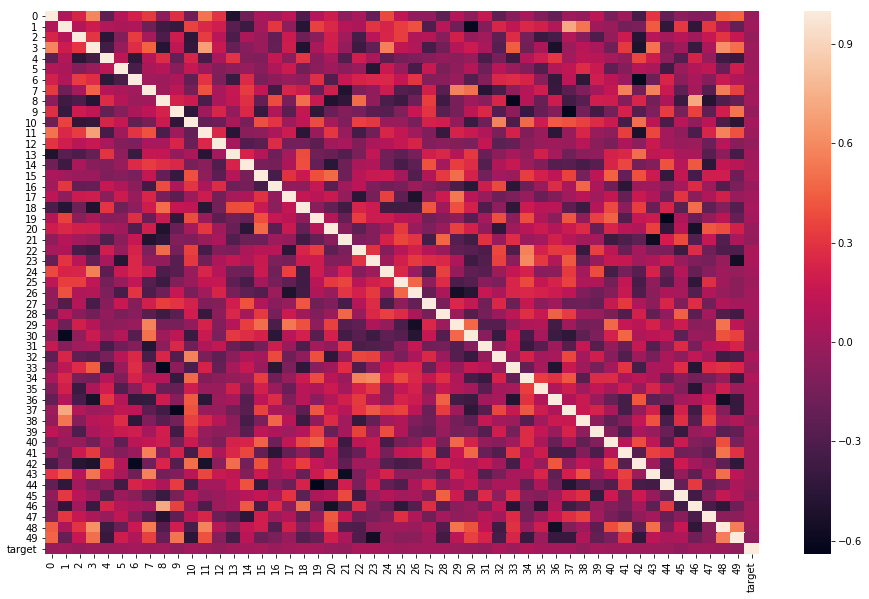

In [5]:
df = pd.DataFrame(X_data)
df['target'] = y_data
sns.heatmap(df.corr());
# title='correlation of features and binary target'

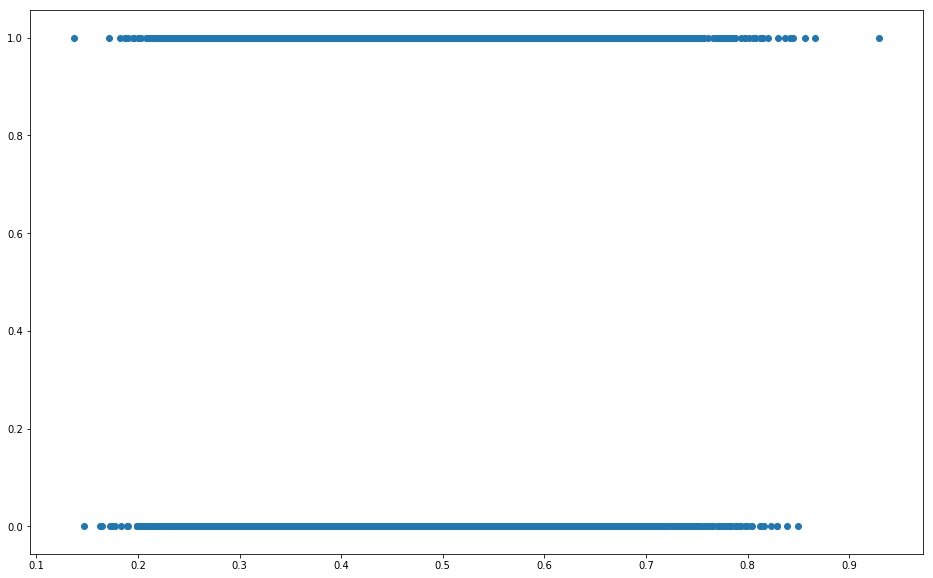

In [6]:
plt.scatter(X_data[:,0], y_data)

In [7]:
M = 128    # batch size during training
y_ph = tf.placeholder(tf.int32, [None])
data = generator([X_data, y_data], M)    

### MODEL

In [8]:
feature_selection = conv_lstm(features=D)

In [9]:
X = tf.placeholder(tf.float32, [None , D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Bernoulli(logits=(ed.dot(X, w)+b))

### INFERENCE

In [10]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Helper functions to maximize the Evidence Lower bound (moved "log" outside compared to standard VAE)

$$ log(p(x)) >= -E_{q(z^1; \lambda), ..., q(z^K; \lambda)} [ \log \frac{1}{K} \sum_{k=1}^K \frac{p(x, z^k)}{q(z^k; \lambda)} ]$$

In [11]:
# inference = IWVI({w: qw,  b: qb}, data={X: X_data, y: y_data})
# inference.run(K=5, n_iter=10000, n_print=1)

alternatively, we use KLqp for batch learning

In [12]:
N = len(X_data)
n_batch = int(N / M)
n_epoch = 100

inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize(n_iter=n_batch * n_epoch, n_samples=5, scale={y: N / M}, logdir='../log')
tf.global_variables_initializer().run()



info_dicts = []
for _ in range(inference.n_iter):
  X_batch, y_batch = next(data)
  info_dict = inference.update({X: X_batch, y_ph: y_batch})
  inference.print_progress(info_dict)
  info_dicts.append(info_dict)

7700/7700 [100%] ██████████████████████████████ Elapsed: 83s | Loss: 8211.476


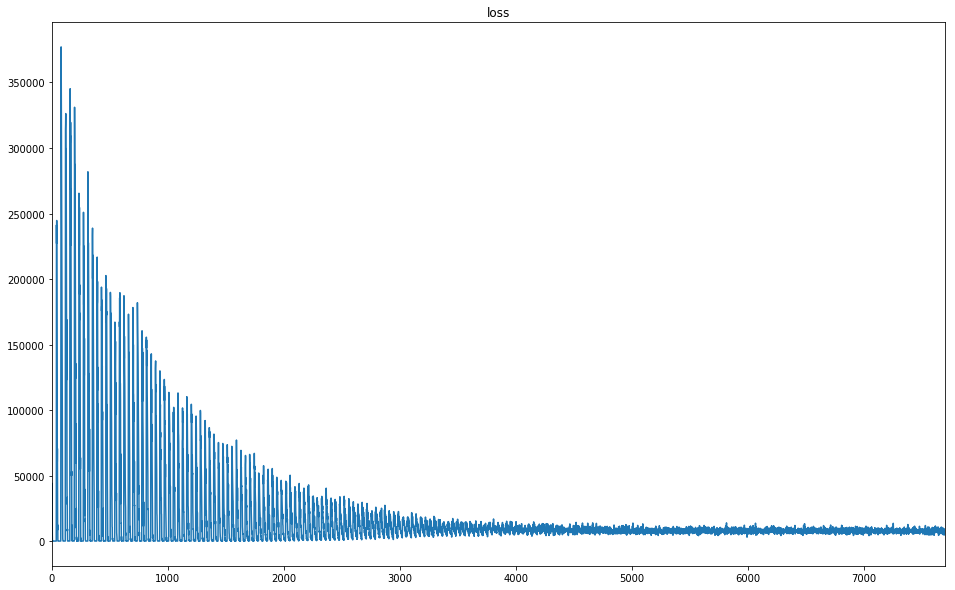

In [13]:
pd.Series([x['loss'] for x in info_dicts]).plot(title='loss');

### CRITICISM

In [14]:
y_post = ed.copy(y, {w: qw, b:qb})

#### todo: implemention of edward's logloss metric is buggy as it accepts predictions instead of logits
#### I've raised an issue here: https://github.com/blei-lab/edward/issues/795

In [15]:
for sam,Xx,yy in [("INS", X_data, y_data), ("OOS",X_test, y_test)]:
    print(sam)
    print("binary_acc:", ed.evaluate('binary_accuracy', data={X: Xx, y_post: yy}))
    print("binary_cross_entropy:", ed.evaluate('log_loss', data={X: Xx, y_post: yy}))  # todo bug in implementation

INS
binary_acc: 0.50998
binary_cross_entropy: 0.749001
OOS
binary_acc: 0.5166
binary_cross_entropy: 0.746671


In [16]:
print("log_loss:", ed.evaluate('log_loss', data={X: X_data, y_post: y_data})) # todo bug in implementation
print("categorical_crossentropy:", ed.evaluate('categorical_crossentropy', data={X: X_data, y_post: y_data}))
print("log_likelihood:", ed.evaluate('log_likelihood', data={X: X_data, y_post: y_data}))

log_loss: 0.74402
categorical_crossentropy: 46193.5
log_likelihood: -0.772037


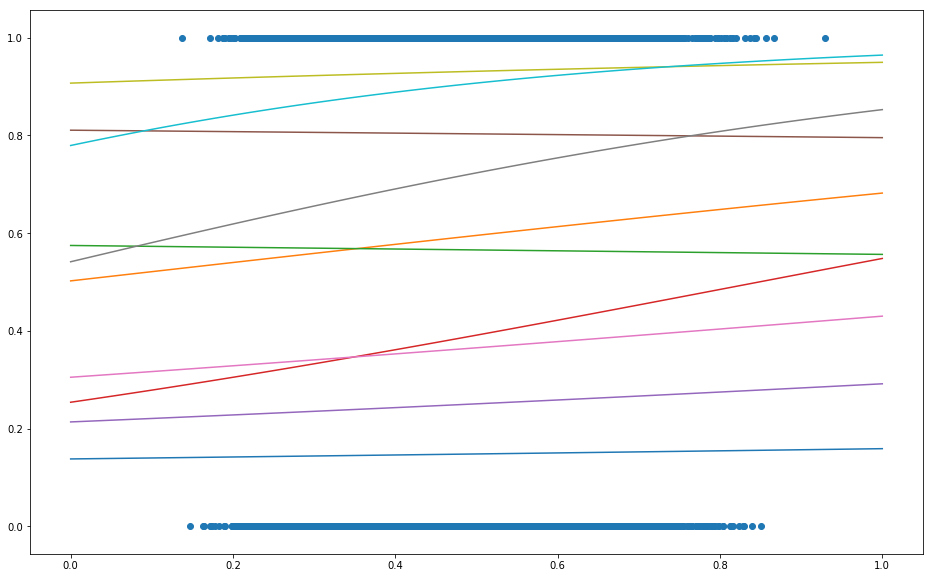

In [17]:
ww = visualise(X_data, y_data, w, b) #prior samples

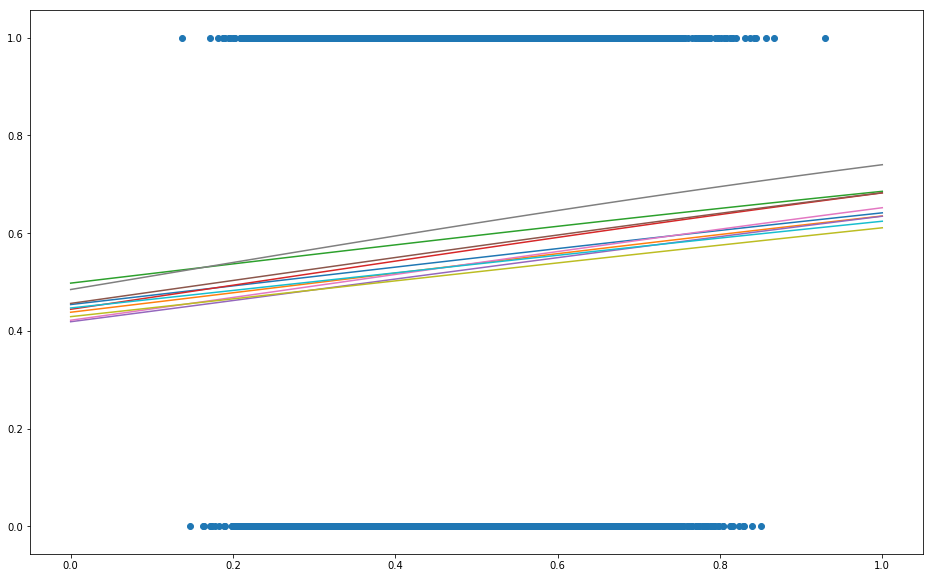

In [18]:
ww = visualise(X_data, y_data, qw, qb) #posterior samples

In [19]:
def binary_crossentropy(y_true, y_pred):
  """Binary cross-entropy.
  Args:
    y_ue: tf.Tensor.
      Tensor of 0s and 1s.
    y_pred: tf.Tensor.
      Tensor of real values (logit probabilities), with same shape as
      `y_true`.
  """
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))

In [20]:
from edward.util import check_data, get_session
from sklearn.metrics import log_loss

def get_y_preds(X_data, y_data, w, b, n_samples=10):
    w_samples = [w.eval() for _ in range(n_samples)]
    b_samples = [b.eval() for _ in range(n_samples)]
    return w_samples, b_samples

def eval_model(Xx, Yy, nom):
    ans = get_y_preds(Xx, Yy, qw, qb, n_samples=10000)
    zw, zb = np.mean(ans[0], axis=0), np.mean(ans[1], axis=0)
    probabilities = sigmoid(Xx.dot(zw) + zb)
    probabilities = probabilities.clip(.49,.51)
    ins = pd.DataFrame(probabilities)
    ins['target'] = Yy
    ins['guess'] = ins[0].round().clip(0,1)
    print(nom, '\n------')
    print('acc:', (ins['target'] == ins['guess']).mean())
    print('sk.logloss:', log_loss(ins['target'], ins[0]))
    sess = get_session()
    print('ed.logloss (corrected):', sess.run(binary_crossentropy(ins['target'], -np.log(1/ins[0] -1)   )   ))
    print('ed.logloss (current):', sess.run(binary_crossentropy(ins['target'], ins[0]   )   ))

    print ('')
    return ins

ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

ins 
------
acc: 0.510282258065
sk.logloss: 0.692923672605
ed.logloss (corrected): 0.692931
ed.logloss (current): 0.723956

oos 
------
acc: 0.52
sk.logloss: 0.692575320595
ed.logloss (corrected): 0.692582
ed.logloss (current): 0.72331



In [21]:
# see how eval metrics look under sample of maximum uncertainy

from edward.util import check_data, get_session
from sklearn.metrics import log_loss

preds = np.array([.5]*1000)
target = np.random.randint(0,2,1000)

print('acc:', (target == preds.round()).mean())
print('logloss:', log_loss(target, preds))
sess = get_session()
print('ed.logloss:', sess.run(binary_crossentropy(target, preds)))

x = preds
z = target
print('tf.doc.logloss', np.mean(x - x * z + np.log(1 + np.exp(-abs(x)))))

acc: 0.494
logloss: 0.69314718056
ed.logloss: 0.721076
tf.doc.logloss 0.72107698418


In [22]:
ins.describe()

,0,target,guess
count,9920.000000,9920.000000,9920.000000
mean,0.499668,0.500000,0.483871
std,0.009828,0.500025,0.499765
min,0.490000,0.000000,0.000000
25%,0.490000,0.000000,0.000000
50%,0.493464,0.500000,0.000000
75%,0.510000,1.000000,1.000000
max,0.510000,1.000000,1.000000


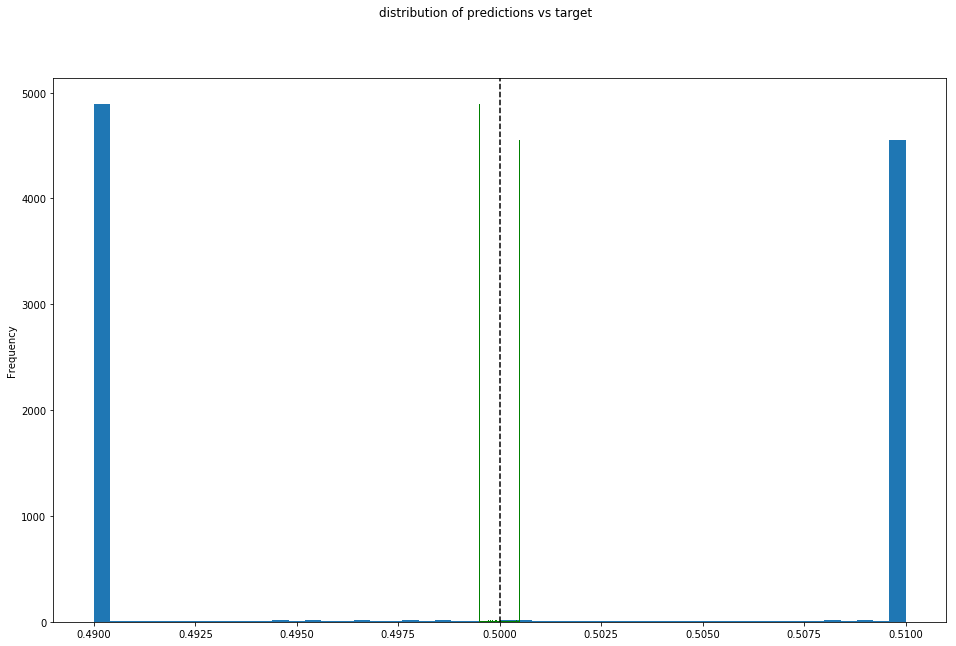

In [23]:
ax = ins[0].plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of predictions vs target', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
#ins['target'].plot(kind='hist', ax=ax[0], color='red', bins=50)

(((ins[0]-.5)*.05)+.5).plot(kind='hist', ax=ax[0], color='green', bins=50); # strinkage around 50%?

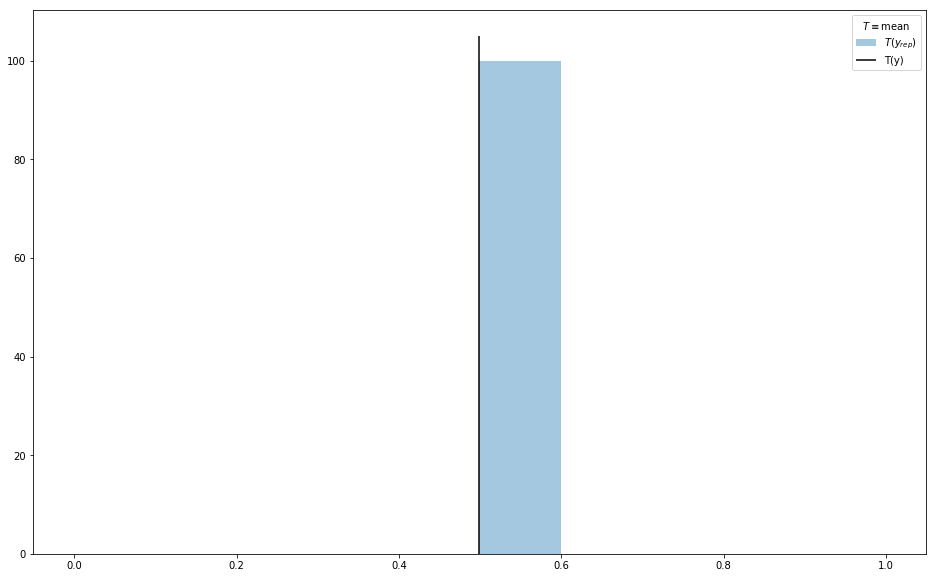

In [24]:
x_post = ed.copy(X, {w: qw, b: qb})
y_rep, y = ed.ppc(
    lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)),
    data={x_post: X_data})

ed.ppc_stat_hist_plot(
    y[0], y_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

In [25]:
ed.ppc(lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)), data={x_post: X_data})

[array([ 0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.49921569,  0.49921569,
         0.49921569,  0.49921569,  0.49921569,  0.4

In [26]:
def T(xs, zs):
    return tf.reduce_max(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_data, y_post: y_data})

In [27]:
qb.sample(50000).eval()

array([[-0.19894728],
       [-0.27072465],
       [-0.33476025],
       ..., 
       [-0.34713942],
       [-0.15565132],
       [-0.1023134 ]], dtype=float32)

In [28]:
## correlation with target is approxmently mean of posterior distribution on parameter

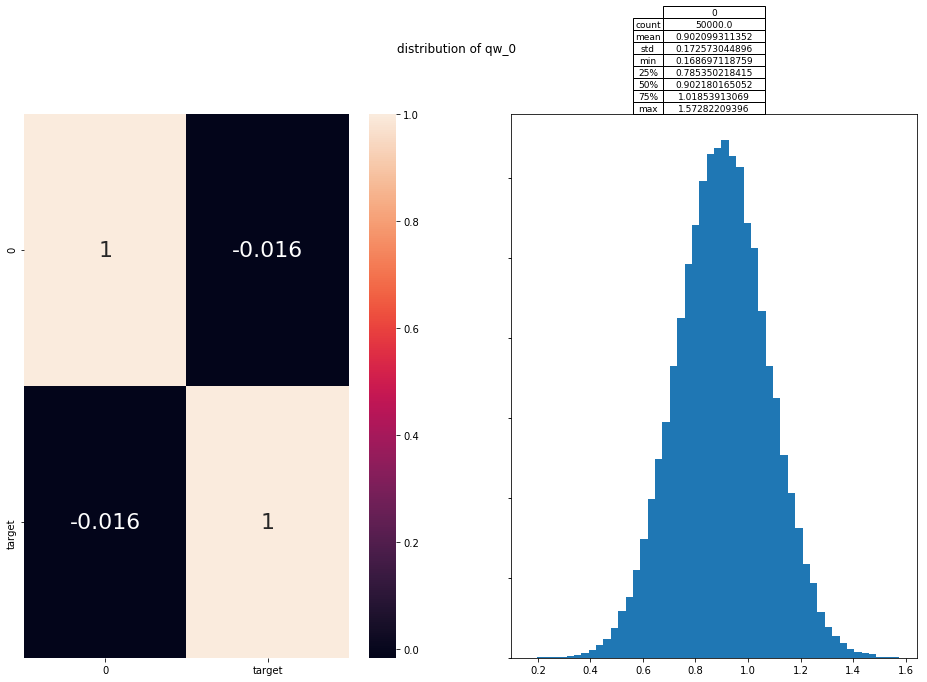

In [29]:
fig, axs = plt.subplots(1,2)


df = pd.DataFrame(X_data[:,0])
df['target'] = y_data
sns.heatmap(df.corr(), annot=True, ax=axs[0], annot_kws={'size':22})
dc = pd.Series(qw.sample(50000).eval()[:,0])
ax = dc.plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of qw_0', bins=50, ax=axs[1])

dcsummary = pd.DataFrame(dc.describe())
plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dcsummary.columns),
          rowLabels=dcsummary.index,
          colLabels=dcsummary.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='top');

In [30]:
dcsummary

,0
count,50000.000000
mean,0.902099
std,0.172573
min,0.168697
25%,0.785350
50%,0.902180
75%,1.018539
max,1.572822


In [31]:
## ppc is 1 since y_data.mean() > 1?

In [32]:
y_data.mean()

0.5

In [33]:
ppc_max

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])]

### baseline comparison

In [34]:
# under toy example, bayesian method looks poor

from sklearn import linear_model

regularization_C = 1e-4 #lower == more regularization
model = linear_model.LogisticRegression(C=regularization_C)
model.fit(X_data, y_data)


print('baseline')
print('--------')
print('ins:', (model.predict_proba(X_data).round()[:,1] == y_data).mean())
print('oos:', (model.predict_proba(X_test).round()[:,1] == y_test).mean())

baseline
--------
ins: 0.526209677419
oos: 0.5231


In [35]:
print('bayesian-forecast')
print('--------')
ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

bayesian-forecast
--------
ins 
------
acc: 0.510080645161
sk.logloss: 0.692941933732
ed.logloss (corrected): 0.692949
ed.logloss (current): 0.723995

oos 
------
acc: 0.5195
sk.logloss: 0.692576346003
ed.logloss (corrected): 0.692583
ed.logloss (current): 0.723314

